## CV02 - ResNet Ablation Study

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

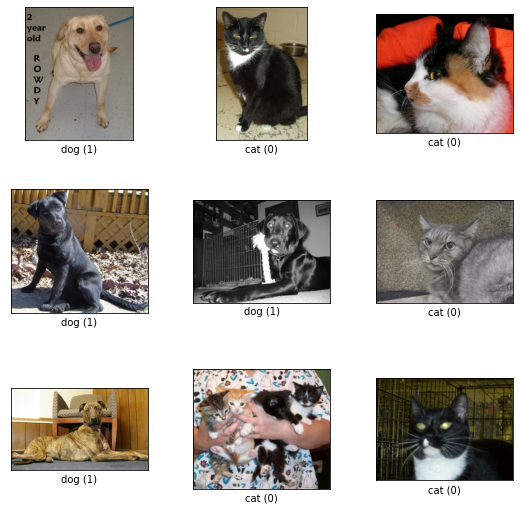

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

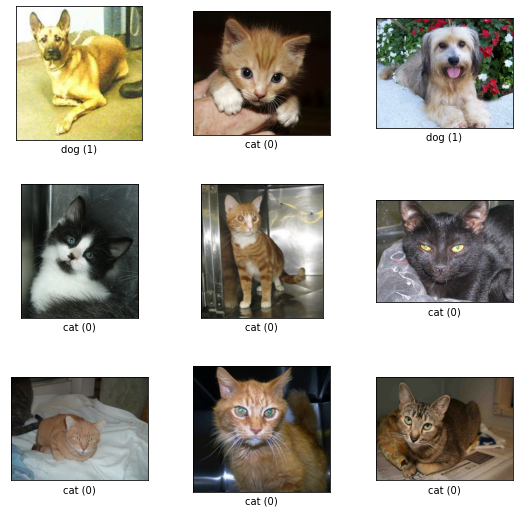

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

### 블록 만들기

In [12]:
# batchnormalization -> activation

def bn_activation(input, stage_name, only_bn, i):
    x = BatchNormalization(axis=3, name=stage_name + 'bn' + str(i))(input)
    if not only_bn:
        x = Activation('relu')(x)
    return x

In [13]:
# shortcut

def _shortcut(shortcut, residual, is_plain, stage_name, i, n, strides):
    
    channel = residual.shape[-1]
    
    if not is_plain:
        x = bn_activation(residual, stage_name, 0, n)
        if i == 0:
            shortcut = Conv2D(filters=channel, kernel_size=(1, 1), strides=strides,
                              padding='valid', kernel_initializer='he_normal',
                              name=stage_name + 'short')(shortcut)
            shortcut = bn_activation(shortcut, stage_name, 0, n + 1)
            x = add([shortcut, x], name=stage_name + 'add')
        else:
            x = add([shortcut, x], name=stage_name + 'add')
        output = Activation('relu')(x)
    else:
        output = bn_activation(residual, stage_name, 0, n)
        
    return output

In [14]:
# ResNet 기본 블록 구현

def resnet_block(input_layer, channel, is_50, is_plain, repetitions, stage):
    
    output = input_layer
    
    for i in range(repetitions):
        stage_name = 'stage' + str(stage + 2) + '_' + str(i + 1) + '_'
        
        init_strides=(1, 1)
        if stage > 0 and i == 0:
            init_strides=(2, 2)
            
        if not is_50:
            x = Conv2D(filters=channel, kernel_size=(3, 3), strides=init_strides,
                       padding='same', kernel_initializer='he_normal',
                       name=stage_name + 'conv1')(output)
            x = bn_activation(x, stage_name, 0, 1)
            x = Conv2D(filters=channel, kernel_size=(3, 3), strides=(1, 1),
                       padding='same', kernel_initializer='he_normal',
                       name=stage_name + 'conv2')(x)
            output = _shortcut(output, x, is_plain, stage_name, i, 2, init_strides)
        else:
            x = Conv2D(filters=channel, kernel_size=(1, 1), strides=init_strides,
                       padding='same', kernel_initializer='he_normal',
                       name=stage_name + 'conv1')(output)
            x = bn_activation(x, stage_name, 0, 1)
            x = Conv2D(filters=channel, kernel_size=(3, 3), strides=(1, 1),
                       padding='same', kernel_initializer='he_normal',
                       name=stage_name + 'conv2')(x)
            x = bn_activation(x, stage_name, 0, 2)
            x = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=(1, 1),
                       padding='same', kernel_initializer='he_normal',
                       name=stage_name + 'conv3')(x)
            
            output = _shortcut(output, x, is_plain, stage_name, i, 3, init_strides)
                
    return output

In [15]:
# 블록을 조합하여 모델 만들기

def build_resnet(input_shape=(32, 32, 3), is_50=False, is_plain=False, num_classes=10):
    
    
    input_layer = Input(shape=input_shape)
    output = input_layer
    output = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same',
                    kernel_initializer='he_normal', name='stage1_0_conv1')(output)
    output = bn_activation(output, 'stage1_0_', 0, 0)
    output = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='stage2_0_maxpooling')(output)
    
    filters = 64
    repetitions = [3, 4, 6, 3]
    for i, c in enumerate(repetitions):
        output = resnet_block(output, channel=filters, is_50=is_50, is_plain=is_plain,
                              repetitions=c, stage=i)
        filters *= 2
        
    output = AveragePooling2D(pool_size=(1, 1), strides=(1, 1), name='stage6_0_avgpooling')(output)
    output = Flatten()(output)
    output = Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

In [16]:
# 34 - residual net

resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_0_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_0_bn0 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_0_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_0_bn0[0][0]               
______________________________________________________________________________________________

In [17]:
# 50 - residual net

resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_0_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_0_bn0 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_0_conv1[0][0]             
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 16, 16, 64)   0           stage1_0_bn0[0][0]               
____________________________________________________________________________________________

### ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34 (Ablation Study)

In [18]:
# 34-ResNet

resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_0_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
stage1_0_bn0 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_0_conv1[0][0]             
__________________________________________________________________________________________________
activation_122 (Activation)     (None, 112, 112, 64) 0           stage1_0_bn0[0][0]               
____________________________________________________________________________________________

In [19]:
# 34-Plain

plain_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, is_plain=True)
plain_34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_0_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_0_bn0 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_175 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [20]:
# 50-ResNet

resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=False)
resnet_50.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_0_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
stage1_0_bn0 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_0_conv1[0][0]             
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 112, 112, 64) 0           stage1_0_bn0[0][0]               
____________________________________________________________________________________________

In [21]:
# 50-Plain

plain_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
plain_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_0_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_0_bn0 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_277 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [22]:
BATCH_SIZE = 32
EPOCH = 15

In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [24]:
# 모델 훈련하기

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 125s 216ms/step - loss: 1.1253 - accuracy: 0.5686 - val_loss: 1.5906 - val_accuracy: 0.5799
Epoch 2/15
581/581 [==============================] - 93s 160ms/step - loss: 0.9190 - accuracy: 0.6234 - val_loss: 0.8319 - val_accuracy: 0.6584
Epoch 3/15
581/581 [==============================] - 93s 161ms/step - loss: 0.7876 - accuracy: 0.6741 - val_loss: 1.2882 - val_accuracy: 0.6210
Epoch 4/15
581/581 [==============================] - 93s 161ms/step - loss: 0.6627 - accuracy: 0.7163 - val_loss: 0.7788 - val_accuracy: 0.6582
Epoch 5/15
581/581 [==============================] - 93s 161ms/step - loss: 0.5480 - accuracy: 0.7642 - val_loss: 0.7760 - val_accuracy: 0.6789
Epoch 6/15
581/581 [==============================] - 93s 161ms/step - loss: 0.4476 - accuracy: 0.8108 - val_loss: 0.7316 - val_accuracy: 0.7290
Epoch 7/15
581/581 [==============================] - 93s 161ms/step - loss: 0.3363 - accuracy: 0.8589 - val_loss: 0.8167 - val_a

In [25]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 85s 146ms/step - loss: 0.8299 - accuracy: 0.5131 - val_loss: 1.2479 - val_accuracy: 0.4968
Epoch 2/15
581/581 [==============================] - 85s 146ms/step - loss: 0.8002 - accuracy: 0.5158 - val_loss: 0.9375 - val_accuracy: 0.5154
Epoch 3/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7894 - accuracy: 0.5141 - val_loss: 1.0083 - val_accuracy: 0.5108
Epoch 4/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7756 - accuracy: 0.5157 - val_loss: 1.0165 - val_accuracy: 0.5165
Epoch 5/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7632 - accuracy: 0.5320 - val_loss: 0.7669 - val_accuracy: 0.5341
Epoch 6/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7418 - accuracy: 0.5327 - val_loss: 0.7417 - val_accuracy: 0.5274
Epoch 7/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7438 - accuracy: 0.5290 - val_loss: 0.7864 - val_ac

In [26]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 221s 381ms/step - loss: 1.5507 - accuracy: 0.5243 - val_loss: 1.6334 - val_accuracy: 0.5181
Epoch 2/15
581/581 [==============================] - 190s 326ms/step - loss: 1.2542 - accuracy: 0.5660 - val_loss: 1.4360 - val_accuracy: 0.5519
Epoch 3/15
581/581 [==============================] - 169s 291ms/step - loss: 1.1881 - accuracy: 0.5770 - val_loss: 1.2385 - val_accuracy: 0.5775
Epoch 4/15
581/581 [==============================] - 170s 292ms/step - loss: 1.0849 - accuracy: 0.5992 - val_loss: 1.7148 - val_accuracy: 0.5781
Epoch 5/15
581/581 [==============================] - 170s 292ms/step - loss: 1.0176 - accuracy: 0.6210 - val_loss: 1.6046 - val_accuracy: 0.5808
Epoch 6/15
581/581 [==============================] - 170s 292ms/step - loss: 0.9694 - accuracy: 0.6412 - val_loss: 0.9751 - val_accuracy: 0.6210
Epoch 7/15
581/581 [==============================] - 170s 292ms/step - loss: 0.9203 - accuracy: 0.6535 - val_loss: 0.7865 -

In [27]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8387 - accuracy: 0.5231 - val_loss: 1.0986 - val_accuracy: 0.5028
Epoch 2/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8204 - accuracy: 0.5299 - val_loss: 1.4169 - val_accuracy: 0.5226
Epoch 3/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8420 - accuracy: 0.5087 - val_loss: 1.4763 - val_accuracy: 0.5149
Epoch 4/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8283 - accuracy: 0.5139 - val_loss: 0.7998 - val_accuracy: 0.4773
Epoch 5/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8221 - accuracy: 0.5172 - val_loss: 1.2108 - val_accuracy: 0.5207
Epoch 6/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8260 - accuracy: 0.5146 - val_loss: 1.0621 - val_accuracy: 0.5065
Epoch 7/15
581/581 [==============================] - 132s 227ms/step - loss: 0.8240 - accuracy: 0.5162 - val_loss: 1.0572 -

In [28]:
# resnet-34 vs plain-34 훈련 손실 그래프 비교

import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

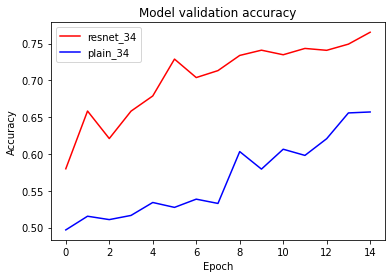

In [30]:
# resnet-34 vs plain-34 검증 정확도 그래프 비교

plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

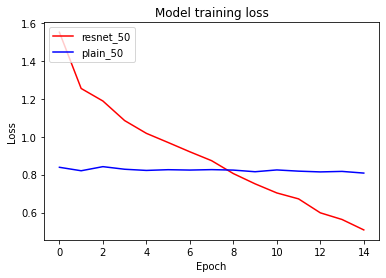

In [31]:
# resnet-50 vs plain-50 훈련 손실 그래프 비교

plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

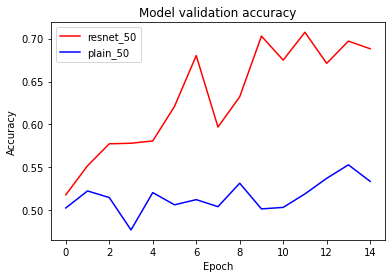

In [32]:
# resnet-50 vs plain-50 훈련 손실 그래프 비교

plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

테스트 결과 resnet모델이 손실 감소가 뚜렷하며 resnet_34가 좀 더 안정적으로 보인다.   
정확도도 역시 plain모델과 뚜렷하게 차이가 나며 resnet모델에서는 resnet_34가 좀 더 높게 나온다.   
skip connection의 힘이 대단하다.   